# STATS201 — Week 5




## 0) Imports + helper functions

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


## 1) Load monthly dataset

In [3]:
df = pd.read_csv("/content/viirs_monthly_country_2012_2024.csv")
print(df.shape)
df.head()


(3874, 18)


,year,month,country,shapeType,shapeGroup,min,max,mean,q1,q2,q3,std,sum,unit,count,cloudFree,date,source_file
0,2012,1,Angola,ADM0,AGO,0.0,1715.93,0.260,0.18,0.24,0.30,1.574,1556551.000,nW/cm²/sr,5977537.0,3.237,2012-01-01,eoatlas-monthly-nightlight-00009.csv
1,2012,2,Angola,ADM0,AGO,0.0,233.14,0.176,0.00,0.17,0.23,0.828,1049819.875,nW/cm²/sr,5977537.0,1.533,2012-02-01,eoatlas-monthly-nightlight-00009.csv
2,2012,3,Angola,ADM0,AGO,0.0,491.36,0.197,0.00,0.23,0.29,0.487,1176871.000,nW/cm²/sr,5977537.0,3.368,2012-03-01,eoatlas-monthly-nightlight-00009.csv
3,2012,4,Angola,ADM0,AGO,0.0,2970.33,0.398,0.34,0.36,0.39,2.522,2379377.250,nW/cm²/sr,5977537.0,11.874,2012-04-01,eoatlas-monthly-nightlight-00009.csv
4,2012,5,Angola,ADM0,AGO,0.0,1850.00,0.253,0.18,0.20,0.22,2.045,1512397.750,nW/cm²/sr,5977537.0,13.389,2012-05-01,eoatlas-monthly-nightlight-00009.csv


## 2) Minimal cleaning + column standardization

We keep fields needed for feature engineering:
- `country` name
- ISO code (`shapeGroup`)
- `year`, `month`
- monthly radiance summary (we try to use `mean` if present)
- spatial heterogeneity (we try to use `std` / `stdDev` if present)


In [4]:
# Inspect columns to map them safely
print(df.columns.tolist())


['year', 'month', 'country', 'shapeType', 'shapeGroup', 'min', 'max', 'mean', 'q1', 'q2', 'q3', 'std', 'sum', 'unit', 'count', 'cloudFree', 'date', 'source_file']


In [5]:
# --- Column mapping (robust to slightly different schemas) ---
def pick_col(candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

col_country = pick_col(["country", "ADM0_NAME", "country_na", "name"])
col_iso     = pick_col(["iso3", "shapeGroup", "ADM0_CODE", "country_co", "ISO3", "iso"])  # ISO3 code
col_year    = pick_col(["year", "Year"])
col_month   = pick_col(["month", "Month"])

# Monthly mean radiance
col_mean = pick_col(["mean", "mean_rad", "avg_rad_mean", "mean_rad_m", "avg_rad"])
# Monthly spatial std dev within country
col_sd   = pick_col(["std", "stdDev", "sd_rad", "sd_rad_m", "avg_rad_std", "stdev"])

print("Mapped columns:")
print("country:", col_country)
print("iso3:", col_iso)
print("year:", col_year)
print("month:", col_month)
print("mean:", col_mean)
print("sd:", col_sd)

keep = [c for c in [col_country, col_iso, col_year, col_month, col_mean, col_sd] if c is not None]
df_m = df[keep].copy()

# Standardize names
rename_map = {}
if col_country: rename_map[col_country] = "country"
if col_iso:     rename_map[col_iso]     = "iso3"
if col_year:    rename_map[col_year]    = "year"
if col_month:   rename_map[col_month]   = "month"
if col_mean:    rename_map[col_mean]    = "mean_rad_m"
if col_sd:      rename_map[col_sd]      = "spatial_sd_m"
df_m = df_m.rename(columns=rename_map)

# Coerce numeric
df_m["year"]  = pd.to_numeric(df_m["year"], errors="coerce")
df_m["month"] = pd.to_numeric(df_m["month"], errors="coerce")
df_m["mean_rad_m"] = pd.to_numeric(df_m["mean_rad_m"], errors="coerce")
if "spatial_sd_m" in df_m.columns:
    df_m["spatial_sd_m"] = pd.to_numeric(df_m["spatial_sd_m"], errors="coerce")

# Keep valid months + drop missing mean radiance
df_m = df_m[(df_m["month"] >= 1) & (df_m["month"] <= 12)].dropna(subset=["iso3","year","month","mean_rad_m"]).copy()

df_m = df_m.sort_values(["iso3","year","month"]).reset_index(drop=True)

print(df_m.shape)
df_m.head()


Mapped columns:
country: country
iso3: shapeGroup
year: year
month: month
mean: mean
sd: std
(3770, 6)


,country,iso3,year,month,mean_rad_m,spatial_sd_m
0,Angola,AGO,2012,1,0.260,1.574
1,Angola,AGO,2012,2,0.176,0.828
2,Angola,AGO,2012,3,0.197,0.487
3,Angola,AGO,2012,4,0.398,2.522
4,Angola,AGO,2012,5,0.253,2.045


## 3) Build country–year features from the monthly panel

From the monthly VIIRS radiance sequence, we construct country–year features only for years with complete 12-month coverage.
This ensures that temporal stability measures are comparable across countries and are not driven by missing observations.
For each country–year, we summarize the monthly sequence into a set of interpretable temporal features that capture average brightness, volatility, and extremes.

- **yearly_mean_mean_rad**: average brightness level (from monthly means)
- **yearly_std_mean_rad**: volatility over months (temporal instability proxy)
- **yearly_min/max/range_mean_rad**: extremes and spread
- **yearly_mean_spatial_sd**: average within-country spatial heterogeneity
- **yearly_std_spatial_sd**: how spatial heterogeneity changes across months


### 3.1 Add infrastructure indicators (optional, addresses professor feedback)

Nighttime lights are our primary representation. To connect to “real-world electricity infrastructure” without redefining labels from the same light features, we added external infrastructure covariates as predictors (not labels).

Below we pull a few World Bank WDI indicators. We merge them by ISO3 code and year so they can be used in an additional feature set for model comparison.

Indicators (WDI codes):
- `EG.ELC.ACCS.ZS` — Access to electricity (% of population)
- `EG.ELC.LOSS.ZS` — Transmission & distribution losses (% of output)
- `EG.USE.ELEC.KH.PC` — Electric power consumption (kWh per capita)
- `EG.ELC.RNEW.ZS` — Renewable electricity output (% of total)


In [6]:
# Optional: pull World Bank WDI indicators via wbgapi (robust long-format output)

try:
    !pip -q install wbgapi

    import wbgapi as wb
    import pandas as pd
    import numpy as np

    wdi_series = {
        "elec_access_pct": "EG.ELC.ACCS.ZS",
        "td_losses_pct": "EG.ELC.LOSS.ZS",
        "elec_kwh_pc": "EG.USE.ELEC.KH.PC",
        "renewable_share_pct": "EG.ELC.RNEW.ZS",
    }

    y_min = int(df_m["year"].min())
    y_max = int(df_m["year"].max())

    iso3_list = sorted(df_m["iso3"].dropna().unique().tolist())

    frames = []
    for nice_name, indicator_code in wdi_series.items():
        tmp = wb.data.DataFrame(
            indicator_code,
            economy=iso3_list,
            time=range(y_min, y_max + 1),
            labels=False
        )

        # tmp index = ISO3, columns = years (often 'YR2012', 'YR2013', ...)
        tmp.index.name = "iso3"

        # ✅ convert columns like 'YR2012' -> 2012 safely
        tmp.columns = [int(str(c).replace("YR", "")) for c in tmp.columns]

        tmp = (
            tmp.reset_index()
               .melt(id_vars="iso3", var_name="year", value_name=nice_name)
        )
        frames.append(tmp)

    wdi = frames[0]
    for f in frames[1:]:
        wdi = wdi.merge(f, on=["iso3", "year"], how="outer")

    wdi["year"] = pd.to_numeric(wdi["year"], errors="coerce")
    for k in wdi_series.keys():
        wdi[k] = pd.to_numeric(wdi[k], errors="coerce")

    print("✅ WDI downloaded:", wdi.shape)
    display(wdi.head())

except Exception as e:
    print("⚠️ WDI download failed (optional). Continuing without WDI features.")
    wdi = None
    print("Error:", repr(e))


✅ WDI downloaded: (338, 6)


,iso3,year,elec_access_pct,td_losses_pct,elec_kwh_pc,renewable_share_pct
0,AGO,2012,37.3,11.271077,271.711997,49.803372
1,AGO,2013,38.4,11.274871,276.087477,44.689266
2,AGO,2014,32.0,11.272498,310.374128,53.430270
3,AGO,2015,42.0,11.270070,306.167407,52.309695
4,AGO,2016,41.8,11.266960,331.664900,59.054089


In [7]:
# Ensure reasonably complete monthly coverage
month_counts = (
    df_m.groupby(["iso3", "year"])["month"]
        .nunique()
        .reset_index(name="n_months")
)

df_m = df_m.merge(month_counts, on=["iso3", "year"])
df_m = df_m[df_m["n_months"] >= 10].copy()


In [8]:
# Aggregate to country-year
g = df_m.groupby(["iso3", "country", "year"], as_index=False)

features = g.agg(
    yearly_mean_mean_rad=("mean_rad_m", "mean"),
    yearly_std_mean_rad=("mean_rad_m", "std"),
    yearly_min_mean_rad=("mean_rad_m", "min"),
    yearly_max_mean_rad=("mean_rad_m", "max"),
)

features["yearly_range_mean_rad"] = features["yearly_max_mean_rad"] - features["yearly_min_mean_rad"]

# Optional spatial heterogeneity summaries if available
if "spatial_sd_m" in df_m.columns:
    spatial = g.agg(
        yearly_mean_spatial_sd=("spatial_sd_m", "mean"),
        yearly_std_spatial_sd=("spatial_sd_m", "std"),
    )
    features = features.merge(spatial, on=["iso3","country","year"], how="left")

print(features.shape)
features.head()


(312, 10)


,iso3,country,year,yearly_mean_mean_rad,yearly_std_mean_rad,yearly_min_mean_rad,yearly_max_mean_rad,yearly_range_mean_rad,yearly_mean_spatial_sd,yearly_std_spatial_sd
0,AGO,Angola,2012,0.269417,0.061832,0.176,0.398,0.222,1.684000,0.673544
1,AGO,Angola,2013,0.260083,0.053458,0.166,0.361,0.195,3.299667,2.432312
2,AGO,Angola,2014,0.268273,0.046904,0.196,0.352,0.156,3.617091,4.568463
3,AGO,Angola,2015,0.266750,0.045613,0.192,0.334,0.142,1.802000,0.803101
4,AGO,Angola,2016,0.236000,0.049238,0.154,0.307,0.153,9.244167,9.943994


## 4) Define labels without circularity (predict next-year volatility)

To circularity, we do notdefine labels using the same-year volatility that appears in features.

Instead:
- Features are computed for year **t**
- Label is based on volatility in year **t+1**

Label definition (multiclass):
Rather than a binary stable/unstable split, we define five instability levels using quintiles of next-year volatility:

- instability_level = 0 → very low next-year volatility

- instability_level = 1 → low next-year volatility

- instability_level = 2 → medium next-year volatility

- instability_level = 3 → high next-year volatility

- instability_level = 4 → very high next-year volatility

Each country–year is assigned to a class based on which quintile its next-year `yearly_std_mean_rad` falls into.

Operationally, this is implemented by shifting each country’s yearly volatility forward by one year, so that the label at year t reflects volatility observed at year t+1.

This makes the task:

“Given this year’s monthly nighttime light pattern summaries, can we predict how unstable the next year will be (very low → very high)?”


In [9]:
# Create next-year target by shifting within each country
features = features.sort_values(["iso3", "year"]).reset_index(drop=True)
features["next_year_std_mean_rad"] = (
    features.groupby("iso3")["yearly_std_mean_rad"].shift(-1)
)

# Drop last year per country (no next-year label)
model_df = features.dropna(subset=["next_year_std_mean_rad"]).copy()

# Multiclass label = quintiles of next-year volatility
# 0 = very low instability, 4 = very high instability
# Keeps no-circularity: features from year T, label from year T+1
model_df["unstable_next"] = pd.qcut(
    model_df["next_year_std_mean_rad"],
    q=5,
    labels=[0, 1, 2, 3, 4]
).astype(int)

print("Class distribution (quintiles of next-year volatility):")
print(model_df["unstable_next"].value_counts().sort_index())

model_df.head()


Class distribution (quintiles of next-year volatility):
unstable_next
0    58
1    57
2    57
3    57
4    57
Name: count, dtype: int64


,iso3,country,year,yearly_mean_mean_rad,yearly_std_mean_rad,yearly_min_mean_rad,yearly_max_mean_rad,yearly_range_mean_rad,yearly_mean_spatial_sd,yearly_std_spatial_sd,next_year_std_mean_rad,unstable_next
0,AGO,Angola,2012,0.269417,0.061832,0.176,0.398,0.222,1.684000,0.673544,0.053458,0
1,AGO,Angola,2013,0.260083,0.053458,0.166,0.361,0.195,3.299667,2.432312,0.046904,0
2,AGO,Angola,2014,0.268273,0.046904,0.196,0.352,0.156,3.617091,4.568463,0.045613,0
3,AGO,Angola,2015,0.266750,0.045613,0.192,0.334,0.142,1.802000,0.803101,0.049238,0
4,AGO,Angola,2016,0.236000,0.049238,0.154,0.307,0.153,9.244167,9.943994,0.067182,1


In [10]:
# Merge WDI infrastructure covariates onto model_df
if wdi is not None:
    wdi_keep = ["iso3", "year", "elec_access_pct", "td_losses_pct", "elec_kwh_pc", "renewable_share_pct"]
    wdi2 = wdi[wdi_keep].drop_duplicates(["iso3","year"])
    before = model_df.shape
    model_df = model_df.merge(wdi2, on=["iso3","year"], how="left")
    print("✅ Merged WDI into model_df:", before, "->", model_df.shape)
else:
    print("ℹ️ No WDI data merged (optional).")


✅ Merged WDI into model_df: (286, 12) -> (286, 16)


## 5) Train/test split (hold-out) + leakage note

We use a 70/30 split with stratification on the label so both classes appear in train/test.


Below we do the standard stratified split first.


In [11]:
# Feature sets for controlled experiments
# A/B/C are VIIRS-derived only (representation choices / ablations).
FEATURE_SET_A = ["yearly_mean_mean_rad", "yearly_std_mean_rad"]  # minimal temporal
FEATURE_SET_B = FEATURE_SET_A + [
    "yearly_range_mean_rad", "yearly_min_mean_rad", "yearly_max_mean_rad"
]  # adds extremes/spread

if "yearly_mean_spatial_sd" in model_df.columns:
    FEATURE_SET_C = FEATURE_SET_B + ["yearly_mean_spatial_sd", "yearly_std_spatial_sd"]  # adds spatial heterogeneity
else:
    FEATURE_SET_C = None

# Optional: add infrastructure covariates (external predictors)
infra_cols = ["elec_access_pct", "td_losses_pct", "elec_kwh_pc", "renewable_share_pct"]
FEATURE_SET_D = None
if all(c in model_df.columns for c in infra_cols):
    FEATURE_SET_D = FEATURE_SET_C or FEATURE_SET_B
    FEATURE_SET_D = FEATURE_SET_D + infra_cols

feature_sets = [
    ("A_min_temporal", FEATURE_SET_A),
    ("B_temporal_plus_extremes", FEATURE_SET_B),
]

if FEATURE_SET_C is not None:
    feature_sets.append(("C_add_spatial_heterogeneity", FEATURE_SET_C))

if FEATURE_SET_D is not None:
    feature_sets.append(("D_add_infrastructure_covariates", FEATURE_SET_D))

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def train_eval(X_cols, model_name="LR", random_state=42):
    X = model_df[X_cols].copy()
    y = model_df["unstable_next"].copy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state, stratify=y
    )

    if model_name == "LR":
        clf = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(
                max_iter=3000,
                multi_class="multinomial"
            ))
        ])
    elif model_name == "RF":
        clf = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("model", RandomForestClassifier(
                n_estimators=300,
                random_state=random_state,
                n_jobs=-1
            ))
        ])
    else:
        raise ValueError("model_name must be 'LR' or 'RF'")

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    # IMPORTANT: this will return per-class metrics + macro/weighted averages
    rep = classification_report(
        y_test, y_pred,
        labels=[0,1,2,3,4],
        output_dict=True,
        zero_division=0
    )

    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4])

    return {
        "accuracy": acc,
        "macro_f1": rep["macro avg"]["f1-score"],
        "weighted_f1": rep["weighted avg"]["f1-score"],
        # focus on class 4 = very high volatility (hard + policy-relevant)
        "f1_class4": rep.get("4", {}).get("f1-score", np.nan),
        "cm": cm,
        "clf": clf,
        "cols": X_cols
    }


## 5.1) “Pixel intensity” distribution demo (single image, lightweight)

We looked at the **distribution of pixel intensities** (e.g., “how much black vs white”) rather than only country-level averages.

Instead of downloading *all* VIIRS rasters, the code below shows a lightweight approach:
- fetch **one** global monthly image as a small thumbnail (e.g., ~640×320),
- convert it to an array,
- plot a histogram/density of pixel values.


In [12]:
import ee
ee.Authenticate()
ee.Initialize(project='stats201')

KeyboardInterrupt: 

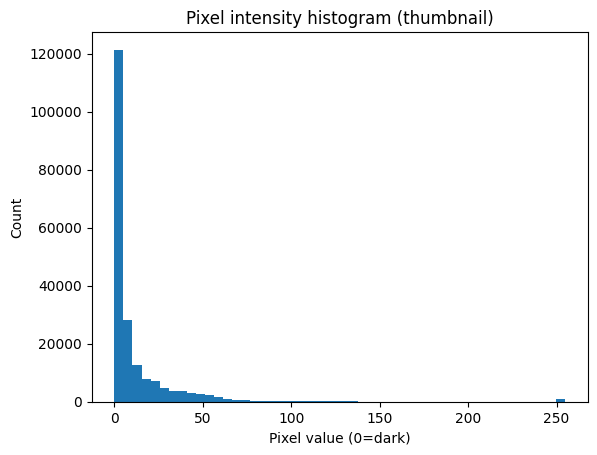

In [38]:
# Earth Engine thumbnail -> pixel histogram

try:
    import ee, requests
    from PIL import Image
    from io import BytesIO
    import matplotlib.pyplot as plt
    import numpy as np

    # Picking random month to visualize
    start = "2020-01-01"
    end   = "2020-02-01"

    img = (ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")
             .filterDate(start, end)
             .first()
             .select("avg_rad"))

    # Create a small thumbnail (global bounds)
    url = img.getThumbURL({
        "min": 0,
        "max": 5,
        "dimensions": "640x320",
        "region": ee.Geometry.Rectangle([-180, -60, 180, 80], proj="EPSG:4326", geodesic=False),
        "format": "png"
    })

    r = requests.get(url)
    r.raise_for_status()
    im = Image.open(BytesIO(r.content)).convert("L")  # grayscale
    arr = np.array(im).ravel()

    # Plot histogram (pixel intensity counts)
    plt.figure()
    plt.hist(arr, bins=50)
    plt.title("Pixel intensity histogram (thumbnail)")
    plt.xlabel("Pixel value (0=dark)")
    plt.ylabel("Count")
    plt.show()

except Exception as e:
    print("⚠️ Optional pixel-histogram demo failed; skipping.")
    print("Error:", repr(e))


## 6) Controlled experiments (two models × feature sets)

We compare:
- Logistic Regression vs Random Forest
- Minimal features (A) vs richer temporal features (B)
- Add spatial heterogeneity (C)


In [13]:
METRIC_KEYS = ["accuracy", "macro_f1", "weighted_f1", "f1_class4"]

experiments = []

for feat_name, cols in feature_sets:
    for model_name in ["LR", "RF"]:
        out = train_eval(cols, model_name=model_name)
        experiments.append({
            "feature_set": feat_name,
            "model": model_name,
            **{k: out[k] for k in METRIC_KEYS}
        })

results = (
    pd.DataFrame(experiments)
      .sort_values(["feature_set", "model"])
      .reset_index(drop=True)
)

results

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

,feature_set,model,accuracy,macro_f1,weighted_f1,f1_class4
0,A_min_temporal,LR,0.732558,0.716013,0.715439,0.941176
1,A_min_temporal,RF,0.686047,0.685292,0.682795,0.909091
2,B_temporal_plus_extremes,LR,0.720930,0.718208,0.716887,0.941176
3,B_temporal_plus_extremes,RF,0.697674,0.695252,0.692805,0.941176
4,C_add_spatial_heterogeneity,LR,0.709302,0.696854,0.696151,0.971429
5,C_add_spatial_heterogeneity,RF,0.732558,0.732328,0.729969,0.941176
6,D_add_infrastructure_covariates,LR,0.686047,0.683203,0.680897,0.971429
7,D_add_infrastructure_covariates,RF,0.697674,0.695061,0.692295,0.941176


In [14]:
# Pick the best configuration by macro F1
best_row = results.sort_values("macro_f1", ascending=False).iloc[0]
best_row


,5
feature_set,C_add_spatial_heterogeneity
model,RF
accuracy,0.732558
macro_f1,0.732328
weighted_f1,0.729969
f1_class4,0.941176


In [15]:
best_feat = best_row["feature_set"]
best_model = best_row["model"]

best_cols = dict(feature_sets)[best_feat]
best_out = train_eval(best_cols, model_name=best_model)

cm_best = best_out["cm"]
clf_best = best_out["clf"]

print("Best:", best_model, "|", best_feat)
print("macro_f1:", round(best_row["macro_f1"], 3), "| f1_class4:", round(best_row["f1_class4"], 3))


Best: RF | C_add_spatial_heterogeneity
macro_f1: 0.732 | f1_class4: 0.941


**Heatmap of the Model Comparison**

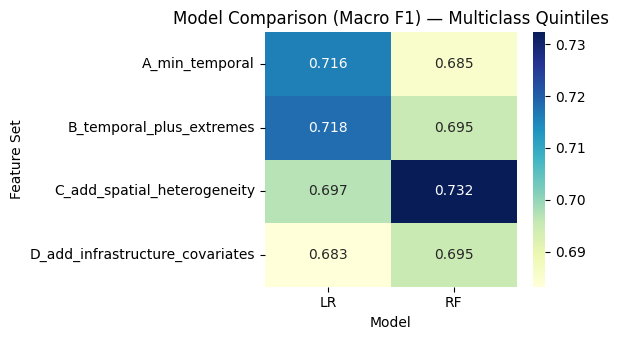

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = results.pivot(index="feature_set", columns="model", values="macro_f1")

plt.figure(figsize=(6,3.5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Model Comparison (Macro F1) — Multiclass Quintiles")
plt.ylabel("Feature Set")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


**Best Model Confusion Matrix**

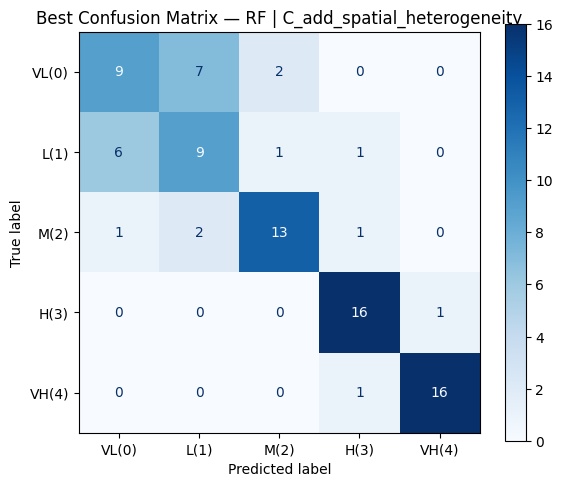

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_best,
    display_labels=["VL(0)","L(1)","M(2)","H(3)","VH(4)"]
)

fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, values_format="d", cmap="Blues", colorbar=True)
ax.set_title(f"Best Confusion Matrix — {best_model} | {best_feat}")
plt.tight_layout()
plt.show()


## 8) Random Forest feature importance (interpretation aid)

The best model is RF and the figure below shows feature importances.


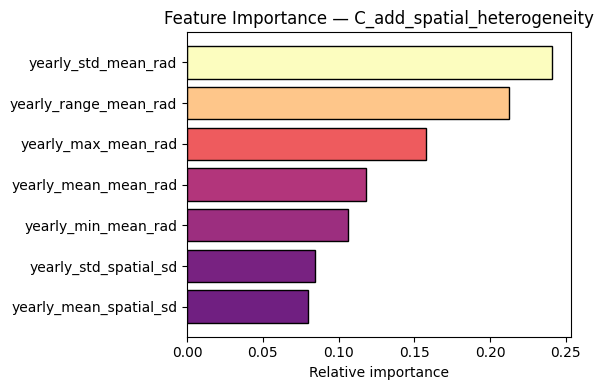

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- RF feature importance for the selected best model ----
if best_model == "RF":
    rf = clf_best.named_steps["model"]          # RandomForestClassifier inside the pipeline
    importances = rf.feature_importances_

    imp = (
        pd.DataFrame({
            "feature": best_cols,
            "importance": importances
        })
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )

    # Prettier bar plot (same style you had)
    colors = plt.cm.magma(imp["importance"] / imp["importance"].max())

    plt.figure(figsize=(6, 4))
    plt.barh(
        imp["feature"],
        imp["importance"],
        color=colors,
        edgecolor="black"
    )
    plt.gca().invert_yaxis()
    plt.xlabel("Relative importance")
    plt.title(f"Feature Importance — {best_feat}")
    plt.tight_layout()
    plt.show()

    imp  # show the table too

else:
    print("Best model is not Random Forest; skip importances.")
